---

# **Project 4: Interpreting BERT Models**  

*(BERT Question Answering with Attribution Analysis)*  

In this project, we leverage a pre-trained BERT model for Question Answering (QA) and employ interpretability techniques to analyze token importance using Captum. The process involves loading a BERT model, making QA predictions, and computing token attributions to better understand the model's decision-making process.  

BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained model designed for natural language understanding tasks such as question answering. Interpreting BERT relies on analyzing input token attributions using attribution methods like Layer-wise Relevance Propagation (LRP) or Shapley values.  

The core mechanism of BERT is based on the attention mechanism, which assigns a weight to each token based on its influence on the model’s response.  

In this project, we apply attribution analysis to examine the contribution of individual tokens to BERT’s predictions. The results highlight the key tokens that significantly influence the model’s answers, providing insights into how BERT processes and understands text.  

### **Interpreting BERT Models (BERT Question Answering with Attribution Analysis)**  

Interpreting BERT models involves attributing the model’s decisions to specific parts of the input text. Attribution analysis aims to determine which parts of the text contribute the most to the prediction. This can be achieved using techniques that measure token importance in the model’s decision-making process. Attribution values are computed by analyzing the gradients of predictions with respect to the input.  

Applying attribution analysis to a BERT model for question answering helps identify the most influential tokens in the generated responses, offering a deeper understanding of the model’s inner workings.  

---

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients

### **Device Setup**
This section sets up the device for computations (GPU if available, else CPU).

In [28]:
# Set up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### **Loading the Model and Tokenizer**
The pre-trained BERT model for Question Answering is loaded, along with its corresponding tokenizer.

In [29]:
model_path = 'bert-base-uncased'

# Load the pre-trained BERT model for Question Answering
model = BertForQuestionAnswering.from_pretrained(model_path)
model.to(device)
model.eval()
model.zero_grad()

# Load the corresponding tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **Defining Helper Functions**
#### **Prediction Function**
This function predicts the start and end logits of the answer span based on the input data.

In [30]:
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                   position_ids=position_ids, attention_mask=attention_mask)
    return output.start_logits, output.end_logits

#### **Custom Forward Function**
This function computes the prediction for a given position (start or end) in the input.

In [31]:
def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values


#### **Functions for Constructing Input and Reference Pairs**
These functions create input and reference pairs for attribution analysis.

- **Input and Reference Token Pairs**:

In [32]:
# Define token IDs for special tokens
ref_token_id = tokenizer.pad_token_id  
sep_token_id = tokenizer.sep_token_id  
cls_token_id = tokenizer.cls_token_id  

def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    """Creates input and reference token sequences for attribution analysis."""
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
        [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)


- **Input and Reference Token Type IDs**:

In [33]:
def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    """Creates input and reference token type IDs."""
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)
    return token_type_ids, ref_token_type_ids

- **Input and Reference Position IDs**:

In [34]:
def construct_input_ref_pos_id_pair(input_ids):
    """Creates input and reference position IDs."""
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids


- **Attention Mask**:

In [35]:
def construct_attention_mask(input_ids):
    """Creates an attention mask to indicate non-padding tokens."""
    return torch.ones_like(input_ids)

- **BERT Embeddings**:

In [36]:
def construct_whole_bert_embeddings(input_ids, ref_input_ids,
                                    token_type_ids=None, ref_token_type_ids=None,
                                    position_ids=None, ref_position_ids=None):
    """Generates BERT embeddings for both input and reference sequences."""
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    return input_embeddings, ref_input_embeddings

## **Preparing Input Data**

The question, text, and reference pairs are constructed here to prepare the model input.

In [37]:
question = "What is important to us?"
text = "It is important to us to include, empower, and support humans of all kinds."

input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

# Convert input indices to tokens for visualization
indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)


## **Defining Ground Truth Answer**

The ground truth answer is defined, and its token indices are extracted.

In [38]:
ground_truth = "include, empower, and support humans of all kinds"

ground_truth_tokens = tokenizer.encode(ground_truth, add_special_tokens=False)
ground_truth_end_ind = indices.index(ground_truth_tokens[-1])
ground_truth_start_ind = ground_truth_end_ind - len(ground_truth_tokens) + 1

## **Model Prediction**

The model's prediction for the start and end positions of the answer is made here.

In [39]:
start_scores, end_scores = predict(input_ids,
                                   token_type_ids=token_type_ids,
                                   position_ids=position_ids,
                                   attention_mask=attention_mask)

print('Question:', question)
print('Predicted Answer:', ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1]))

Question: What is important to us?
Predicted Answer: 


## **Computing Token Importance with LayerIntegratedGradients**

The importance of tokens for both the start and end positions is computed using Captum's `LayerIntegratedGradients`.

In [40]:
lig = LayerIntegratedGradients(squad_pos_forward_func, model.bert.embeddings)

attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                                baselines=ref_input_ids,
                                                additional_forward_args=(token_type_ids, position_ids, attention_mask, 0),
                                                return_convergence_delta=True)
attributions_end, delta_end = lig.attribute(inputs=input_ids,
                                            baselines=ref_input_ids,
                                            additional_forward_args=(token_type_ids, position_ids, attention_mask, 1),
                                            return_convergence_delta=True)

## **Summarizing Attributions**

This function computes the sum of the attributions for each token and normalizes them.

In [41]:
def summarize_attributions(attributions):
    """Computes the sum of attributions for each token."""
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

attributions_start_sum = summarize_attributions(attributions_start)
attributions_end_sum = summarize_attributions(attributions_end)

## **Visualizing Attributions**

The attributions for the start and end positions are visualized using Captum's `visualize_text`.

In [42]:
start_position_vis = viz.VisualizationDataRecord(
    attributions_start_sum,
    torch.max(torch.softmax(start_scores[0], dim=0)),
    torch.argmax(start_scores),
    torch.argmax(start_scores),
    str(ground_truth_start_ind),
    attributions_start_sum.sum(),
    all_tokens,
    delta_start
)

end_position_vis = viz.VisualizationDataRecord(
    attributions_end_sum,
    torch.max(torch.softmax(end_scores[0], dim=0)),
    torch.argmax(end_scores),
    torch.argmax(end_scores),
    str(ground_truth_end_ind),
    attributions_end_sum.sum(),
    all_tokens,
    delta_end
)

print("Token Importance Attribution for Answer Start and End:")
viz.visualize_text([start_position_vis, end_position_vis])


Token Importance Attribution for Answer Start and End:


## **Multi-Embedding Attribution Analysis**

### **Overview**
This section examines the contributions of different sub-embeddings (`word_embeddings`, `token_type_embeddings`, and `position_embeddings`) in `BertEmbeddings` towards predicting both start and end positions in a given text. We use `LayerIntegratedGradients` to compute attributions for each embedding type.


---

### **Computing Multi-Embedding Attributions**

1. **Defining the Attribution Method**  
   We instantiate `LayerIntegratedGradients` to compute the attributions for all three embeddings:  

In [43]:
lig2 = LayerIntegratedGradients(squad_pos_forward_func, [
       model.bert.embeddings.word_embeddings, 
       model.bert.embeddings.token_type_embeddings, 
       model.bert.embeddings.position_embeddings
   ])

c:\Users\somem\AppData\Local\Programs\Python\Python312\Lib\site-packages\captum\attr\_core\layer\layer_integrated_gradients.py:101: UserWarning: Multiple layers provided. Please ensure that each layer is**not** solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.
  warnings.warn(


2. **Attributing the Start and End Positions**  
   The attributions for start and end positions are computed by passing input embeddings and their corresponding reference baselines:

In [44]:
attributions_start = lig2.attribute(
       inputs=(input_ids, token_type_ids, position_ids),
       baselines=(ref_input_ids, ref_token_type_ids, ref_position_ids),
       additional_forward_args=(attention_mask, 0)
   )

attributions_end = lig2.attribute(
       inputs=(input_ids, token_type_ids, position_ids),
       baselines=(ref_input_ids, ref_token_type_ids, ref_position_ids),
       additional_forward_args=(attention_mask, 1)
   )

3. **Summarizing the Attributions**  
   The attributions are summarized separately for each embedding type:

In [45]:
attributions_start_word = summarize_attributions(attributions_start[0])
attributions_end_word = summarize_attributions(attributions_end[0])

attributions_start_token_type = summarize_attributions(attributions_start[1])
attributions_end_token_type = summarize_attributions(attributions_end[1])

attributions_start_position = summarize_attributions(attributions_start[2])
attributions_end_position = summarize_attributions(attributions_end[2])

---

### **Identifying Top Contributing Tokens**

To analyze which tokens contribute the most, we define a function to retrieve the top-k attributed tokens:


In [46]:
def get_topk_attributed_tokens(attrs, k=5):
    values, indices = torch.topk(attrs, k)
    top_tokens = [all_tokens[idx] for idx in indices]
    return top_tokens, values, indices

Using this function, we compute the most influential tokens for each embedding type:

In [47]:
top_words_start, top_words_val_start, top_word_ind_start = get_topk_attributed_tokens(attributions_start_word)
top_words_end, top_words_val_end, top_words_ind_end = get_topk_attributed_tokens(attributions_end_word)

top_token_type_start, top_token_type_val_start, top_token_type_ind_start = get_topk_attributed_tokens(attributions_start_token_type)
top_token_type_end, top_token_type_val_end, top_token_type_ind_end = get_topk_attributed_tokens(attributions_end_token_type)

top_pos_start, top_pos_val_start, pos_ind_start = get_topk_attributed_tokens(attributions_start_position)
top_pos_end, top_pos_val_end, pos_ind_end = get_topk_attributed_tokens(attributions_end_position)

---

### **Visualizing the Results**

The top contributing tokens are stored in a pandas DataFrame for better visualization:


In [48]:
df_start = pd.DataFrame({
    'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words_start, top_word_ind_start, top_words_val_start)],
    'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type_start, top_token_type_ind_start, top_words_val_start)],
    'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos_start, pos_ind_start, top_pos_val_start)]
})
display(df_start) 

,"Word(Index), Attribution","Token Type(Index), Attribution","Position(Index), Attribution"
0,", (15), 0.38","and (19), 0.38","us (12), 0.66"
1,", (18), 0.34","all (23), 0.34","##power (17), 0.54"
2,"us (12), 0.16","of (22), 0.16","humans (21), 0.24"
3,"##power (17), 0.12","it (8), 0.12","all (23), 0.19"
4,"support (20), 0.06",", (18), 0.06","support (20), 0.16"


Similarly, a DataFrame is created for end positions:

In [49]:
df_end = pd.DataFrame({
    'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words_end, top_words_ind_end, top_words_val_end)],
    'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type_end, top_token_type_ind_end, top_words_val_end)],
    'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos_end, pos_ind_end, top_pos_val_end)]
})
display(df_end)

,"Word(Index), Attribution","Token Type(Index), Attribution","Position(Index), Attribution"
0,". (25), 0.14","##power (17), 0.14","what (1), 0.46"
1,", (15), 0.11","include (14), 0.11","humans (21), 0.39"
2,", (18), 0.11","of (22), 0.11","important (3), 0.25"
3,"important (3), 0.08","humans (21), 0.08","us (12), 0.23"
4,"include (14), 0.04",", (15), 0.04","us (5), 0.22"


The top 5 attributions for start and end positions can now be analyzed.

---

### **Interpreting BERT Layers** 

Now, we analyze attribution scores across BERT’s layers using the `LayerConductance` method.  

1. **Defining a Custom Forward Function**  
   Since `LayerConductance` requires embeddings as input, we define a new forward function:

In [50]:
def squad_pos_forward_func2(input_emb, attention_mask=None, position=0):
       pred = model(inputs_embeds=input_emb, attention_mask=attention_mask)
       pred = pred[position]
       return pred.max(1).values

2. **Computing Layer-Wise Attributions**  
   We iterate over all BERT layers and compute the attribution scores for each token:


In [51]:
layer_attrs_start = []
layer_attrs_end = []

token_to_explain = 23  # Index of the token to analyze in detail
layer_attrs_start_dist = []
layer_attrs_end_dist = []

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(
    input_ids, ref_input_ids,
    token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids,
    position_ids=position_ids, ref_position_ids=ref_position_ids
)

for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(squad_pos_forward_func2, model.bert.encoder.layer[i])
    layer_attributions_start = lc.attribute(
        inputs=input_embeddings, 
        baselines=ref_input_embeddings, 
        additional_forward_args=(attention_mask, 0)
    )
    layer_attributions_end = lc.attribute(
        inputs=input_embeddings, 
        baselines=ref_input_embeddings, 
        additional_forward_args=(attention_mask, 1)
    )

    layer_attrs_start.append(summarize_attributions(layer_attributions_start).cpu().detach().tolist())
    layer_attrs_end.append(summarize_attributions(layer_attributions_end).cpu().detach().tolist())

    # Storing attributions for the specific token of interest
    layer_attrs_start_dist.append(layer_attributions_start[0, token_to_explain, :].cpu().detach().tolist())
    layer_attrs_end_dist.append(layer_attributions_end[0, token_to_explain, :].cpu().detach().tolist())

---

### **Visualizing Layer Attributions**  

1. **Start Position Heatmap** 

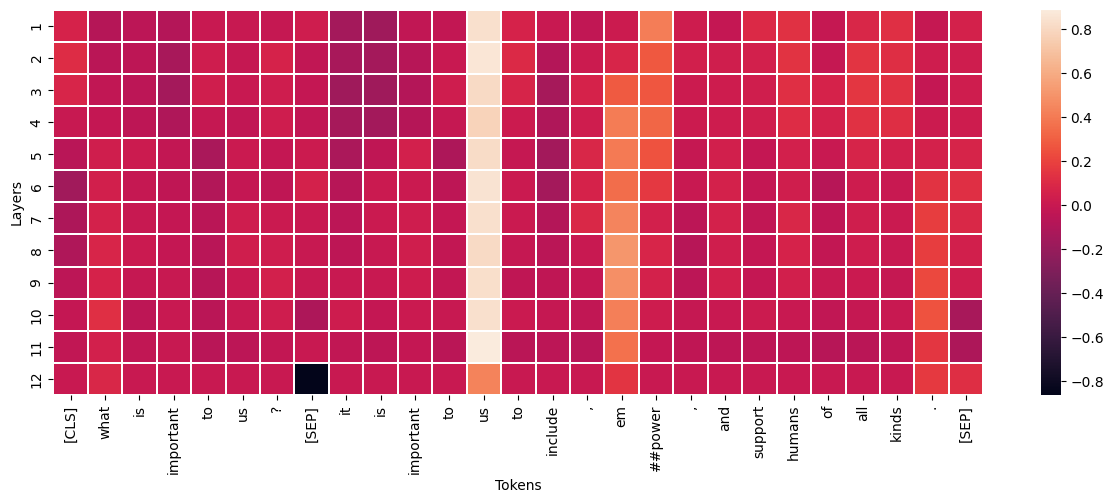

In [52]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels = all_tokens
yticklabels = list(range(1, 13))
ax = sns.heatmap(np.array(layer_attrs_start), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

 - The heatmap shows a strong attribution signal for the question word `"what"` in layers 1-9.
   - Some tokens like `"important"`, `"us"`, and `"to"` gain attribution in the last layers.
   - The correct predicted token `"to"` for start position has a strong attribution in the final layers.

2. **End Position Heatmap** 

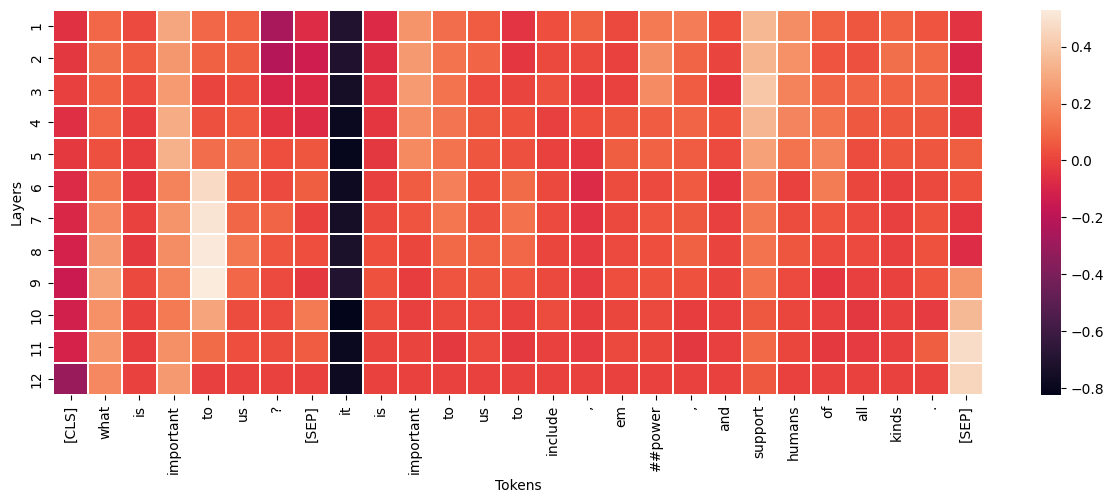

In [53]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels = all_tokens
yticklabels = list(range(1, 13))
ax = sns.heatmap(np.array(layer_attrs_end), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()


  - The `"what"` token has strong attribution in almost all layers.
   - The correct predicted token `"kinds"` gains positive attribution, especially in the last two layers.

---

## **Conclusion**

This project successfully leverages BERT for question answering and applies Captum's attribution methods to analyze token importance. The results offer valuable insights into the interpretation and explanation of model decisions in natural language processing tasks. This analysis reveals how different embeddings and layers contribute to BERT’s predictions. The multi-embedding attribution and layer conductance techniques enable a detailed understanding of BERT’s decision-making process at a granular level.